# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [29]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

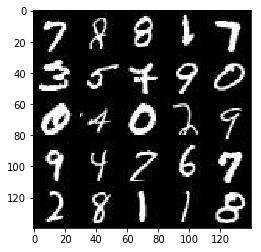

In [30]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

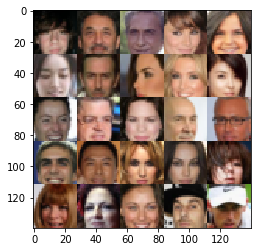

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [33]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32,(None,z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #28x28x1
        
        conv1 = tf.layers.conv2d(images,64,5,strides=2, padding='same')
        relu1 = tf.maximum(alpha*conv1,conv1)
        #14x14x64
        #print(relu1.shape)
        
        conv2 = tf.layers.conv2d(relu1,128,5,strides=2, padding='same')
        bn2 =tf.layers.batch_normalization(conv2,training =True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        #7x7x128
        #print(relu2.shape)
        
        conv3 = tf.layers.conv2d(relu2,256,5,strides=2, padding='same')
        bn3 =tf.layers.batch_normalization(conv3,training =True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        #4x4x256
        #print(relu3.shape)
        
        flat = tf.reshape(relu3,(-1, 4*4*256))
        
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse = reuse):
        
        #scope.reuse_variables()
        
        d1 = tf.layers.dense(z,7*7*256)
        
        d1 = tf.reshape(d1,(-1,7,7,256))
        d1 = tf.layers.batch_normalization(d1,training = is_train)
        d1 = tf.maximum(alpha*d1,d1)
        #7x7x256
        #print(d1.shape)
        
        conv1 = tf.layers.conv2d_transpose(d1,128,5,strides = 2, padding = 'same')
        conv1 = tf.layers.batch_normalization(conv1,training=is_train)
        conv1 = tf.maximum(alpha*conv1,conv1)
        #14x14x128
        #print(conv1.shape)
        
        conv2 = tf.layers.conv2d_transpose(conv1,64,5,strides = 2, padding = 'same')
        conv2 = tf.layers.batch_normalization(conv2,training=is_train)
        conv2 = tf.maximum(alpha*conv2,conv2)
        #28x28x64
        
        logits = tf.layers.conv2d_transpose(conv2,out_channel_dim,5,strides = 1, padding = 'same')
        
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #data_shape = np.array(data_shape)
    #print(data_shape)
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    
    d_loss, g_loss = model_loss( input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate,beta1)
    
    tot_steps = epoch_count * (int)(data_shape[0]/batch_size)
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps+=1
                #rescaling from -0.5 to 0.5 to -1 to 1
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if (steps % 20 == 0) or (steps == tot_steps):
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epochs: {}/{} step: {}/{} ".format(epoch_i+1,epoch_count, steps, tot_steps), 
                            "Discriminator loss: {:.4f}".format(train_loss_d),
                            "Generator loss: {:.4f}".format(train_loss_g))
                    
                
                if (steps % 200 == 0) or (steps == tot_steps):
                    show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epochs: 1/2 step: 20/936  Discriminator loss: 0.8485 Generator loss: 2.5759
Epochs: 1/2 step: 40/936  Discriminator loss: 0.8886 Generator loss: 1.0462
Epochs: 1/2 step: 60/936  Discriminator loss: 1.3440 Generator loss: 0.5675
Epochs: 1/2 step: 80/936  Discriminator loss: 0.9610 Generator loss: 1.7624
Epochs: 1/2 step: 100/936  Discriminator loss: 0.9987 Generator loss: 1.3070
Epochs: 1/2 step: 120/936  Discriminator loss: 1.0724 Generator loss: 1.1760
Epochs: 1/2 step: 140/936  Discriminator loss: 0.9468 Generator loss: 1.1125
Epochs: 1/2 step: 160/936  Discriminator loss: 1.0064 Generator loss: 0.8939
Epochs: 1/2 step: 180/936  Discriminator loss: 1.0492 Generator loss: 0.7617
Epochs: 1/2 step: 200/936  Discriminator loss: 0.8529 Generator loss: 1.1850


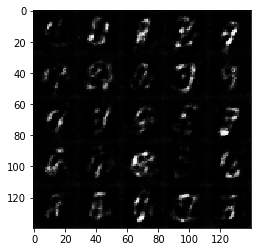

Epochs: 1/2 step: 220/936  Discriminator loss: 0.9661 Generator loss: 0.9159
Epochs: 1/2 step: 240/936  Discriminator loss: 0.8344 Generator loss: 1.1395
Epochs: 1/2 step: 260/936  Discriminator loss: 0.7496 Generator loss: 1.5727
Epochs: 1/2 step: 280/936  Discriminator loss: 0.8577 Generator loss: 1.0859
Epochs: 1/2 step: 300/936  Discriminator loss: 0.7141 Generator loss: 1.9973
Epochs: 1/2 step: 320/936  Discriminator loss: 0.8501 Generator loss: 1.0700
Epochs: 1/2 step: 340/936  Discriminator loss: 0.7862 Generator loss: 1.2168
Epochs: 1/2 step: 360/936  Discriminator loss: 0.7078 Generator loss: 1.5997
Epochs: 1/2 step: 380/936  Discriminator loss: 0.7044 Generator loss: 1.5158
Epochs: 1/2 step: 400/936  Discriminator loss: 0.6436 Generator loss: 2.2502


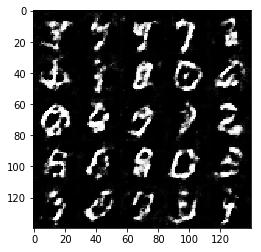

Epochs: 1/2 step: 420/936  Discriminator loss: 0.7165 Generator loss: 1.4431
Epochs: 1/2 step: 440/936  Discriminator loss: 1.0286 Generator loss: 0.8305
Epochs: 1/2 step: 460/936  Discriminator loss: 0.8717 Generator loss: 2.3684
Epochs: 2/2 step: 480/936  Discriminator loss: 0.8941 Generator loss: 2.0911
Epochs: 2/2 step: 500/936  Discriminator loss: 0.8154 Generator loss: 1.1981
Epochs: 2/2 step: 520/936  Discriminator loss: 1.0713 Generator loss: 2.5198
Epochs: 2/2 step: 540/936  Discriminator loss: 1.0049 Generator loss: 0.9134
Epochs: 2/2 step: 560/936  Discriminator loss: 1.0721 Generator loss: 0.7674
Epochs: 2/2 step: 580/936  Discriminator loss: 0.8112 Generator loss: 1.6608
Epochs: 2/2 step: 600/936  Discriminator loss: 0.9262 Generator loss: 1.9789


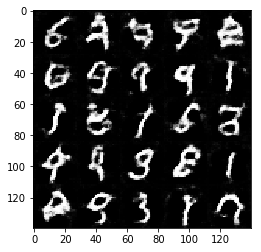

Epochs: 2/2 step: 620/936  Discriminator loss: 0.9630 Generator loss: 0.8846
Epochs: 2/2 step: 640/936  Discriminator loss: 0.8631 Generator loss: 1.2978
Epochs: 2/2 step: 660/936  Discriminator loss: 1.2592 Generator loss: 0.5987
Epochs: 2/2 step: 680/936  Discriminator loss: 0.8279 Generator loss: 1.4730
Epochs: 2/2 step: 700/936  Discriminator loss: 0.9376 Generator loss: 0.9801
Epochs: 2/2 step: 720/936  Discriminator loss: 0.9145 Generator loss: 1.1906
Epochs: 2/2 step: 740/936  Discriminator loss: 0.8662 Generator loss: 1.4829
Epochs: 2/2 step: 760/936  Discriminator loss: 0.9857 Generator loss: 0.9307
Epochs: 2/2 step: 780/936  Discriminator loss: 0.9037 Generator loss: 1.4770
Epochs: 2/2 step: 800/936  Discriminator loss: 1.0072 Generator loss: 1.7386


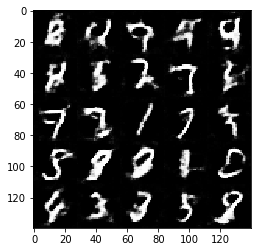

Epochs: 2/2 step: 820/936  Discriminator loss: 0.9016 Generator loss: 1.7716
Epochs: 2/2 step: 840/936  Discriminator loss: 0.8700 Generator loss: 1.5579
Epochs: 2/2 step: 860/936  Discriminator loss: 0.9384 Generator loss: 1.0319
Epochs: 2/2 step: 880/936  Discriminator loss: 0.8240 Generator loss: 1.7746
Epochs: 2/2 step: 900/936  Discriminator loss: 1.0564 Generator loss: 0.8765
Epochs: 2/2 step: 920/936  Discriminator loss: 1.0191 Generator loss: 2.1701
Epochs: 2/2 step: 936/936  Discriminator loss: 0.8848 Generator loss: 1.5948


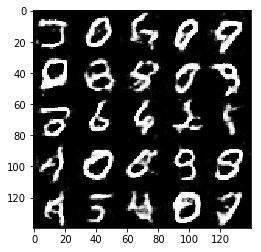

In [40]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epochs: 1/1 step: 20/1582  Discriminator loss: 0.5092 Generator loss: 2.6475
Epochs: 1/1 step: 40/1582  Discriminator loss: 0.4539 Generator loss: 2.8503
Epochs: 1/1 step: 60/1582  Discriminator loss: 0.4778 Generator loss: 2.8504
Epochs: 1/1 step: 80/1582  Discriminator loss: 0.5595 Generator loss: 2.1735
Epochs: 1/1 step: 100/1582  Discriminator loss: 0.5672 Generator loss: 2.2391
Epochs: 1/1 step: 120/1582  Discriminator loss: 0.5161 Generator loss: 2.8717
Epochs: 1/1 step: 140/1582  Discriminator loss: 0.6057 Generator loss: 3.2226
Epochs: 1/1 step: 160/1582  Discriminator loss: 0.7970 Generator loss: 1.4588
Epochs: 1/1 step: 180/1582  Discriminator loss: 0.6820 Generator loss: 2.2986
Epochs: 1/1 step: 200/1582  Discriminator loss: 0.6930 Generator loss: 1.7696


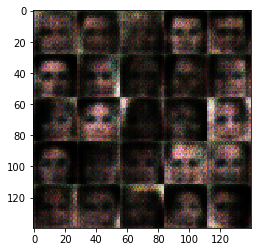

Epochs: 1/1 step: 220/1582  Discriminator loss: 0.6677 Generator loss: 1.8999
Epochs: 1/1 step: 240/1582  Discriminator loss: 0.8664 Generator loss: 1.7298
Epochs: 1/1 step: 260/1582  Discriminator loss: 1.0567 Generator loss: 0.8830
Epochs: 1/1 step: 280/1582  Discriminator loss: 0.6461 Generator loss: 2.3705
Epochs: 1/1 step: 300/1582  Discriminator loss: 0.9259 Generator loss: 1.1415
Epochs: 1/1 step: 320/1582  Discriminator loss: 0.6407 Generator loss: 1.9114
Epochs: 1/1 step: 340/1582  Discriminator loss: 0.8178 Generator loss: 1.7624
Epochs: 1/1 step: 360/1582  Discriminator loss: 0.7203 Generator loss: 1.6595
Epochs: 1/1 step: 380/1582  Discriminator loss: 0.8037 Generator loss: 1.7366
Epochs: 1/1 step: 400/1582  Discriminator loss: 0.8980 Generator loss: 1.1046


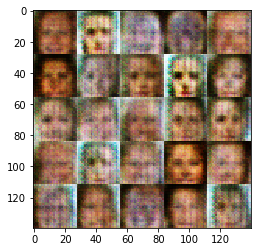

Epochs: 1/1 step: 420/1582  Discriminator loss: 0.7576 Generator loss: 1.4417
Epochs: 1/1 step: 440/1582  Discriminator loss: 0.7098 Generator loss: 1.8552
Epochs: 1/1 step: 460/1582  Discriminator loss: 0.8124 Generator loss: 1.3671
Epochs: 1/1 step: 480/1582  Discriminator loss: 0.7583 Generator loss: 1.5325
Epochs: 1/1 step: 500/1582  Discriminator loss: 0.7852 Generator loss: 1.8073
Epochs: 1/1 step: 520/1582  Discriminator loss: 0.9232 Generator loss: 1.7618
Epochs: 1/1 step: 540/1582  Discriminator loss: 1.0399 Generator loss: 1.1632
Epochs: 1/1 step: 560/1582  Discriminator loss: 0.8998 Generator loss: 2.1722
Epochs: 1/1 step: 580/1582  Discriminator loss: 1.0466 Generator loss: 0.9845
Epochs: 1/1 step: 600/1582  Discriminator loss: 0.9580 Generator loss: 1.8938


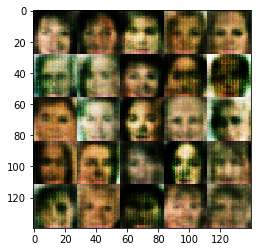

Epochs: 1/1 step: 620/1582  Discriminator loss: 0.8962 Generator loss: 1.3990
Epochs: 1/1 step: 640/1582  Discriminator loss: 0.9692 Generator loss: 1.1122
Epochs: 1/1 step: 660/1582  Discriminator loss: 0.8361 Generator loss: 1.3721
Epochs: 1/1 step: 680/1582  Discriminator loss: 0.9818 Generator loss: 1.9457
Epochs: 1/1 step: 700/1582  Discriminator loss: 0.7886 Generator loss: 1.6502
Epochs: 1/1 step: 720/1582  Discriminator loss: 1.0785 Generator loss: 1.2380
Epochs: 1/1 step: 740/1582  Discriminator loss: 1.1479 Generator loss: 1.4340
Epochs: 1/1 step: 760/1582  Discriminator loss: 1.3224 Generator loss: 0.8209
Epochs: 1/1 step: 780/1582  Discriminator loss: 0.9003 Generator loss: 1.5035
Epochs: 1/1 step: 800/1582  Discriminator loss: 0.9899 Generator loss: 1.3180


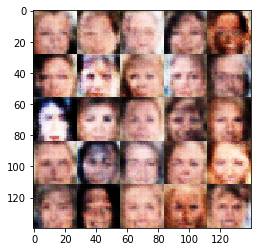

Epochs: 1/1 step: 820/1582  Discriminator loss: 0.8763 Generator loss: 1.7090
Epochs: 1/1 step: 840/1582  Discriminator loss: 1.0596 Generator loss: 1.5984
Epochs: 1/1 step: 860/1582  Discriminator loss: 1.0785 Generator loss: 1.3628
Epochs: 1/1 step: 880/1582  Discriminator loss: 1.0140 Generator loss: 1.3509
Epochs: 1/1 step: 900/1582  Discriminator loss: 1.0563 Generator loss: 1.1515
Epochs: 1/1 step: 920/1582  Discriminator loss: 1.0303 Generator loss: 1.0187
Epochs: 1/1 step: 940/1582  Discriminator loss: 1.0693 Generator loss: 1.4427
Epochs: 1/1 step: 960/1582  Discriminator loss: 1.2207 Generator loss: 1.1546
Epochs: 1/1 step: 980/1582  Discriminator loss: 1.0853 Generator loss: 1.3441
Epochs: 1/1 step: 1000/1582  Discriminator loss: 1.0848 Generator loss: 1.1194


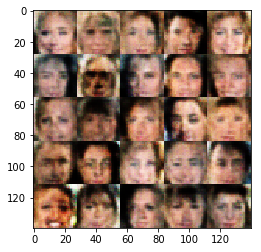

Epochs: 1/1 step: 1020/1582  Discriminator loss: 0.9736 Generator loss: 1.6218
Epochs: 1/1 step: 1040/1582  Discriminator loss: 0.8877 Generator loss: 1.2683
Epochs: 1/1 step: 1060/1582  Discriminator loss: 0.8617 Generator loss: 1.4180
Epochs: 1/1 step: 1080/1582  Discriminator loss: 0.9332 Generator loss: 1.0943
Epochs: 1/1 step: 1100/1582  Discriminator loss: 0.9688 Generator loss: 1.3473
Epochs: 1/1 step: 1120/1582  Discriminator loss: 1.2511 Generator loss: 0.9081
Epochs: 1/1 step: 1140/1582  Discriminator loss: 0.7997 Generator loss: 1.5872
Epochs: 1/1 step: 1160/1582  Discriminator loss: 0.7756 Generator loss: 1.7430
Epochs: 1/1 step: 1180/1582  Discriminator loss: 0.9722 Generator loss: 1.3055
Epochs: 1/1 step: 1200/1582  Discriminator loss: 0.9365 Generator loss: 1.0378


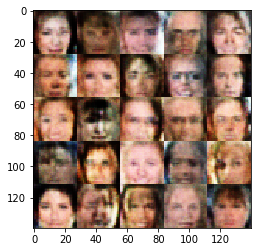

Epochs: 1/1 step: 1220/1582  Discriminator loss: 0.8011 Generator loss: 1.3743
Epochs: 1/1 step: 1240/1582  Discriminator loss: 0.8709 Generator loss: 1.2120
Epochs: 1/1 step: 1260/1582  Discriminator loss: 0.8646 Generator loss: 1.3225
Epochs: 1/1 step: 1280/1582  Discriminator loss: 0.8819 Generator loss: 1.1476
Epochs: 1/1 step: 1300/1582  Discriminator loss: 1.0523 Generator loss: 1.0068
Epochs: 1/1 step: 1320/1582  Discriminator loss: 0.7663 Generator loss: 1.3969
Epochs: 1/1 step: 1340/1582  Discriminator loss: 1.2952 Generator loss: 2.5163
Epochs: 1/1 step: 1360/1582  Discriminator loss: 1.0018 Generator loss: 0.9429
Epochs: 1/1 step: 1380/1582  Discriminator loss: 1.0693 Generator loss: 0.8080
Epochs: 1/1 step: 1400/1582  Discriminator loss: 0.9568 Generator loss: 1.0317


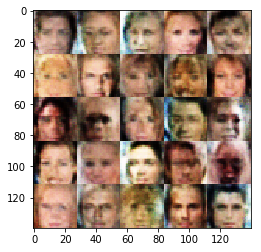

Epochs: 1/1 step: 1420/1582  Discriminator loss: 0.9715 Generator loss: 1.1907
Epochs: 1/1 step: 1440/1582  Discriminator loss: 0.7251 Generator loss: 1.6986
Epochs: 1/1 step: 1460/1582  Discriminator loss: 0.7595 Generator loss: 1.3303
Epochs: 1/1 step: 1480/1582  Discriminator loss: 0.8950 Generator loss: 1.0460
Epochs: 1/1 step: 1500/1582  Discriminator loss: 0.8961 Generator loss: 1.7127
Epochs: 1/1 step: 1520/1582  Discriminator loss: 0.7446 Generator loss: 2.0315
Epochs: 1/1 step: 1540/1582  Discriminator loss: 0.8989 Generator loss: 1.2125
Epochs: 1/1 step: 1560/1582  Discriminator loss: 1.0192 Generator loss: 0.8634
Epochs: 1/1 step: 1580/1582  Discriminator loss: 0.9134 Generator loss: 1.0164
Epochs: 1/1 step: 1582/1582  Discriminator loss: 0.8568 Generator loss: 1.2285


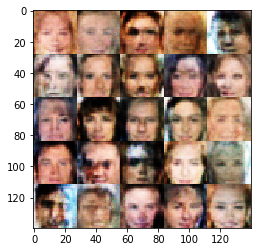

In [41]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.